In [1]:
from util import *

from src.dataset import load_mnist
from src.counterfactual import get_baseline_counterfactuals
import joblib

import warnings
warnings.filterwarnings('ignore')
                        
# Get a model
model = joblib.load('models/mnist.gz') # Model should have the BlackBox interface
model

2022-11-13 16:37:06.837963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


MnistModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=10, bias=True)
)

In [2]:
loader = iter(load_mnist(100, train=False))
X_corpus, _ = next(loader)
X_test, _ = next(loader)

simplex = get_simplex(model, X_corpus, X_test, verbose = True)

Weight Fitting Epoch: 2000/10000 ; Error: 7.04e+03 ; Regulator: 60.3 ; Reg Factor: 1
Weight Fitting Epoch: 4000/10000 ; Error: 3.81e+03 ; Regulator: 25.5 ; Reg Factor: 1
Weight Fitting Epoch: 6000/10000 ; Error: 3.37e+03 ; Regulator: 14 ; Reg Factor: 1
Weight Fitting Epoch: 8000/10000 ; Error: 3.26e+03 ; Regulator: 9.64 ; Reg Factor: 1
Weight Fitting Epoch: 10000/10000 ; Error: 3.21e+03 ; Regulator: 7.75 ; Reg Factor: 1


In [3]:
%%time
test_id = 1

cfs, x, desired_class = get_simplex_cf_image(simplex, model, test_id, n_cfs = 1)

CPU times: user 1.59 s, sys: 21.8 ms, total: 1.61 s
Wall time: 202 ms


Original || Counterfactual || Diff 


<Figure size 200x600 with 0 Axes>

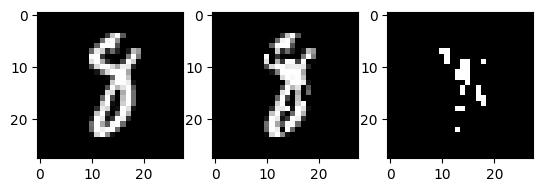

Predicted:  tensor(1)  ||  Desired:  tensor(1)  ||  Orginal:  tensor(8)
Sparsity =  tensor(0.0332)



In [4]:
display_image_cfs(cfs, model, x, desired_class)

Original || Counterfactual || Diff 


<Figure size 200x600 with 0 Axes>

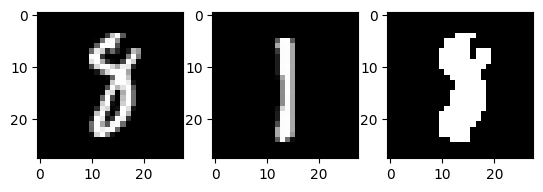

Predicted:  tensor(1)  ||  Desired:  tensor(1)  ||  Orginal:  tensor(8)
Sparsity =  tensor(0.1837)



In [5]:
baseline_cfs = get_baseline_counterfactuals(model = model, target = desired_class, test = x, \
                                            corpus = X_corpus)
display_image_cfs(baseline_cfs, model, x, desired_class)

2022-11-13 16:37:56.297160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Original || Counterfactual || Diff 


<Figure size 200x600 with 0 Axes>

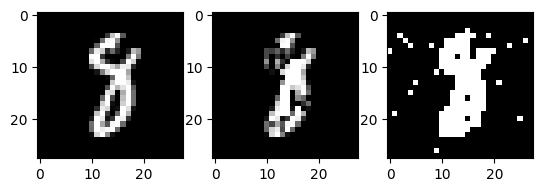

Predicted:  tensor(1)  ||  Desired:  tensor(1)  ||  Orginal:  tensor(8)
Sparsity =  tensor(0.1952)

CPU times: user 8min 4s, sys: 23.6 s, total: 8min 27s
Wall time: 1min 3s


In [8]:
%%time
cf_proto_cf = get_cf_nproto_cf(X_corpus, model, x)
display_image_cfs(cf_proto_cf, model, x, desired_class)

# Comparison

In [10]:
from tqdm import tqdm 
import time

times = []
sparsity = []

for test_id in tqdm(range(20)):
    start = time.time()
    cfs, x, desired_class = get_simplex_cf_image(simplex, model, test_id)
    if cfs is None:
        cfs = torch.ones_like(x)
    end = time.time()
    
    start_b = time.time()
    baseline_cfs = get_baseline_counterfactuals(model = model, target = desired_class, test = x, \
                                            corpus = X_corpus)
    end_b = time.time()
    
    start_c = time.time()
    cf_proto_cf = get_cf_nproto_cf(X_corpus, model, x)
    end_c = time.time()
    
    times.append([end - start, end_b - start_b, end_c - start_c])
    sparsity.append([(cfs[0] != x).sum(), (baseline_cfs[0] != x).sum(), (cf_proto_cf[0] != x).sum()])

100%|███████████████████████████████████████████| 20/20 [26:22<00:00, 79.14s/it]


In [11]:
pd.DataFrame(times, columns  = ['simplex', 'nn', 'cfproto']).describe().to_csv('results/mnist_times.csv')

In [12]:
pd.DataFrame(sparsity, columns  = ['simplex', 'nn', 'cfproto']).applymap(int).describe().to_csv('results/mnist_sparsity.csv')